# ノート 5: ML による簡単な回帰

### 目標: 1 つの特徴量（予測変数、入力変数）と 1 つの ML モデルを用いて ML による学習の基礎を身につける

### 問題設定の確認

1. 各画像は雷雲を含んでいるか（分類問題）
2. 各画像にはいくつの発雷があるか（回帰問題）

### 背景

回帰問題での ML の学習方法も分類問題と基本的には同じです。ノートのラベル `y` を少し変えるだけで同じ手順で実行します。


### Step 1 & 2: パッケージのインポートと分類問題用のデータの読み込み

ユーティリティ関数の `features_to_keep` 引数の値を変えて特徴量を 1 つだけ取り出します。`class_labels=False` に変えてラベルを分類問題用に再計算せずに読み込みます。


In [1]:
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

import sys

sys.path.insert(1, "../scripts/")
from aux_functions import load_n_combine_df


In [2]:
(X_train, y_train), (X_validate, y_validate), (X_test, y_test) = load_n_combine_df(
    path_to_data="../datasets/sevir/",
    features_to_keep=np.arange(0, 1, 1),  # 1番目の特徴量だけ
    class_labels=False,  # ラベルのクラス化を無効にする
)

ラベルが 0 と 1 の二分値ではなく、連続した値であることをプロットして確認します。


Text(0.5, 0, 'number of flahses')

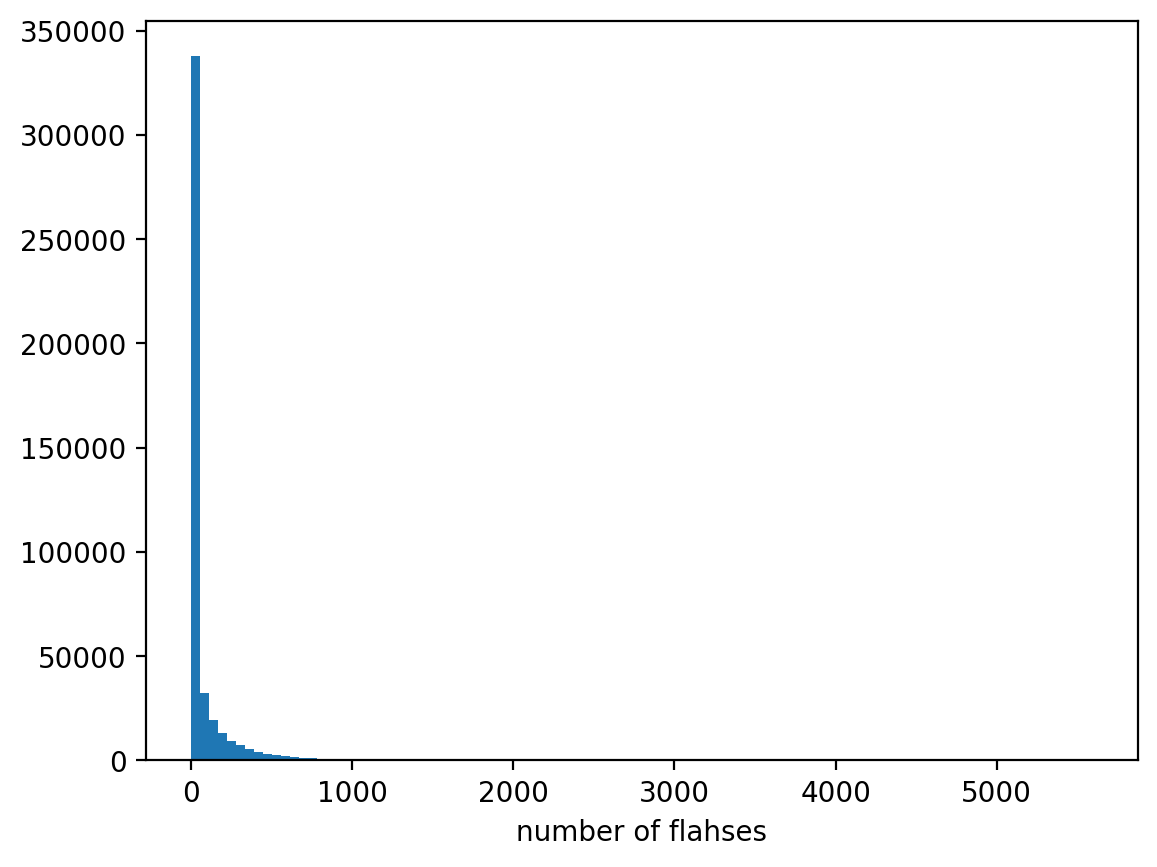

In [3]:
plt.hist(y_train, bins=100)
plt.xlabel("number of flahses")

発雷数のデータになっていることが確認できました。
発雷数を最低輝度温度の関数として表すことができないか散布図から確認してみます。


Text(0, 0.5, 'Number of flashes')

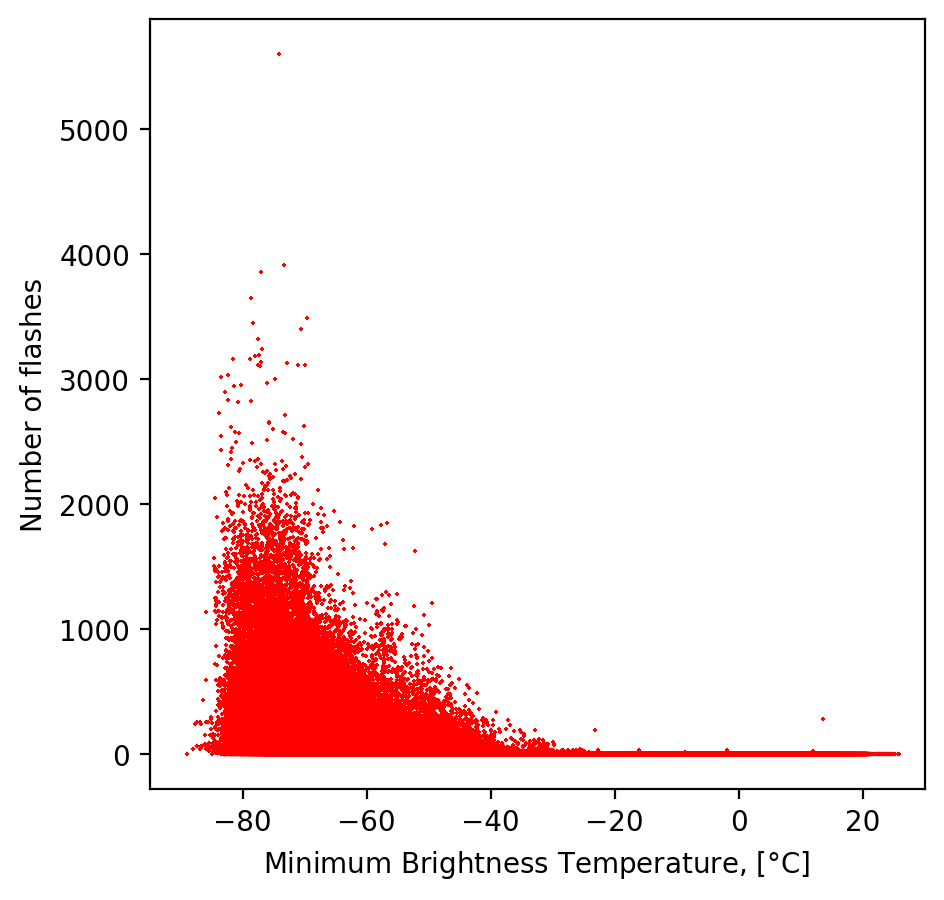

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(X_train[:, 0], y_train, color="r", s=1, marker="+")

ax.set_xlim([-95, 30])
ax.set_xlabel(r"Minimum Brightness Temperature, [$\degree$C]")
ax.set_ylabel("Number of flashes")

直線で当てはめる（線形回帰）のは非常に難しいことが分かると思います。


### Step 3: モデルの初期化

モデル名のクラスのインスタンスを作成して初期化します。


In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
print(model)

LinearRegression()


### Step 4: ML モデルの学習

ノート 4 と全く同じです。


In [6]:
model = model.fit(X_train, y_train)

### Step 5: ML モデルの評価

まずは x 軸に予測された発雷数を y 軸に真値となる発雷数をプロットしてみます（one-to-one plot）。
完全予測の場合は対角線に沿った分布になるはずです。


Text(0.5, 0, 'GLM measurement, [$number of flashes$]')

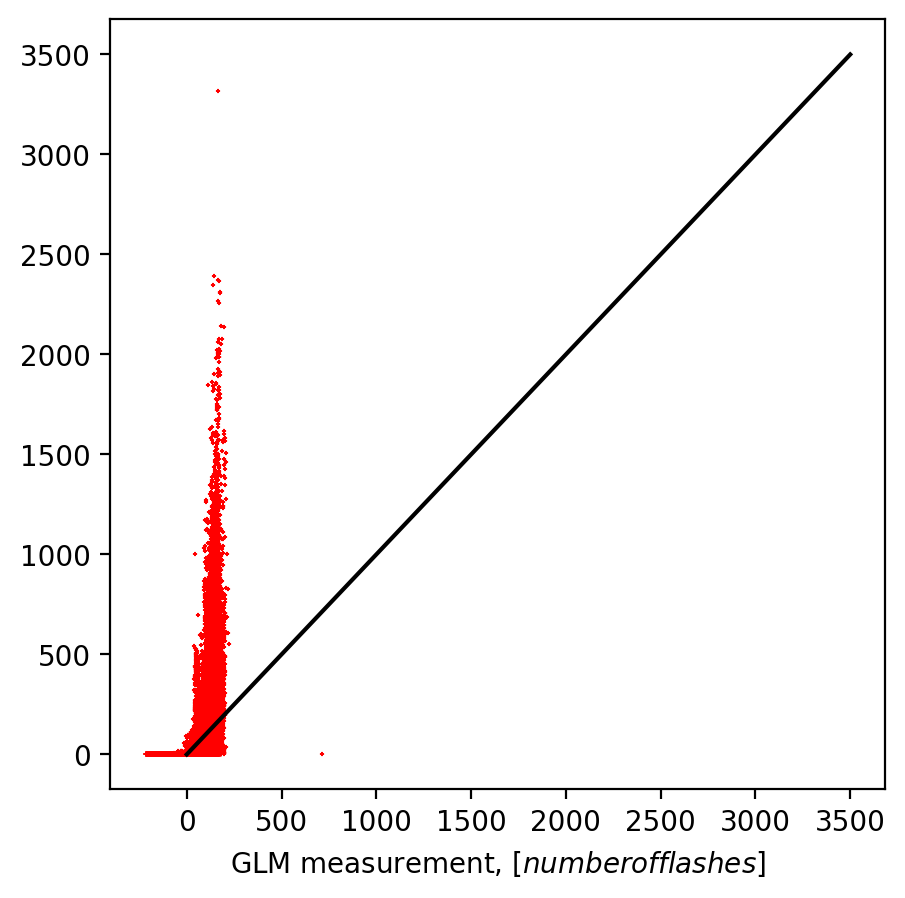

In [7]:
# 予測値の計算
yhat = model.predict(X_validate)

fig, ax = plt.subplots(figsize=(5, 5))

# 予測値（検証データのXからの予測） - 真値（検証データのy）をプロット
ax.scatter(yhat, y_validate, color="r", s=1, marker="+")
ax.plot([0, 3500], [0, 3500], "-k")  # 対角線
ax.set_xlabel("ML Prediction, [$number of flashes$]")
ax.set_xlabel("GLM measurement, [$number of flashes$]")

予測された発雷数と真値の発雷数に対応関係があるようには見えません。
このような場合 1 つ以上の発雷がある事例だけで学習を行う方法があります。
ずるいやり方のように思えるかもしれませんが、発雷の有無を予測する分類問題の学習モデルは 90%以上の正解率の性能があったので
二つの ML モデルを併用して使った場合に相当していると考えることもできます。
つまり、分類モデルで発雷ありと予測された事例の画像のみを用いて回帰モデルの学習を行うこともできるのです。

データセットから発雷なしのデータを削除しましょう。


In [8]:
(X_train, y_train), (X_validate, y_validate), (X_test, y_test) = load_n_combine_df(
    path_to_data="../datasets/sevir/",
    features_to_keep=np.arange(0, 1, 1),  # インデックス[0]の特徴量のみ
    class_labels=False,  # 分類なし
    dropzeros=True,  # ゼロ値を落とす
)

print(np.min(y_train))

1


データの最小値は 1 でラベルのベクトル `y` には発雷数 0 は含まれていません。散布図をプロットします。


Text(0, 0.5, 'Number of flashes')

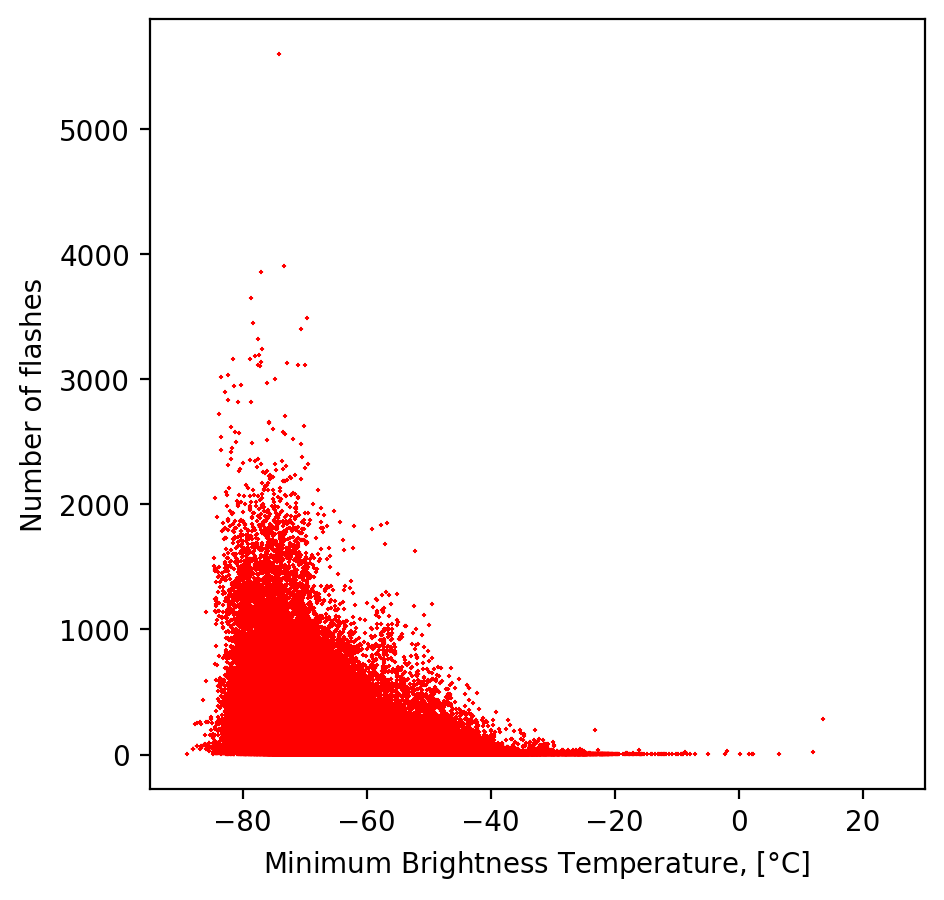

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(X_train[:, 0], y_train, color="r", s=1, marker="+")

ax.set_xlim([-95, 30])
ax.set_xlabel(r"Minimum Brightness Temperature, [$\degree$C]")
ax.set_ylabel("Number of flashes")

モデルを再度学習させましょう。


In [10]:
model = model.fit(X_train, y_train)

Text(0.5, 0, 'GLM measurement, [$number of flashes$]')

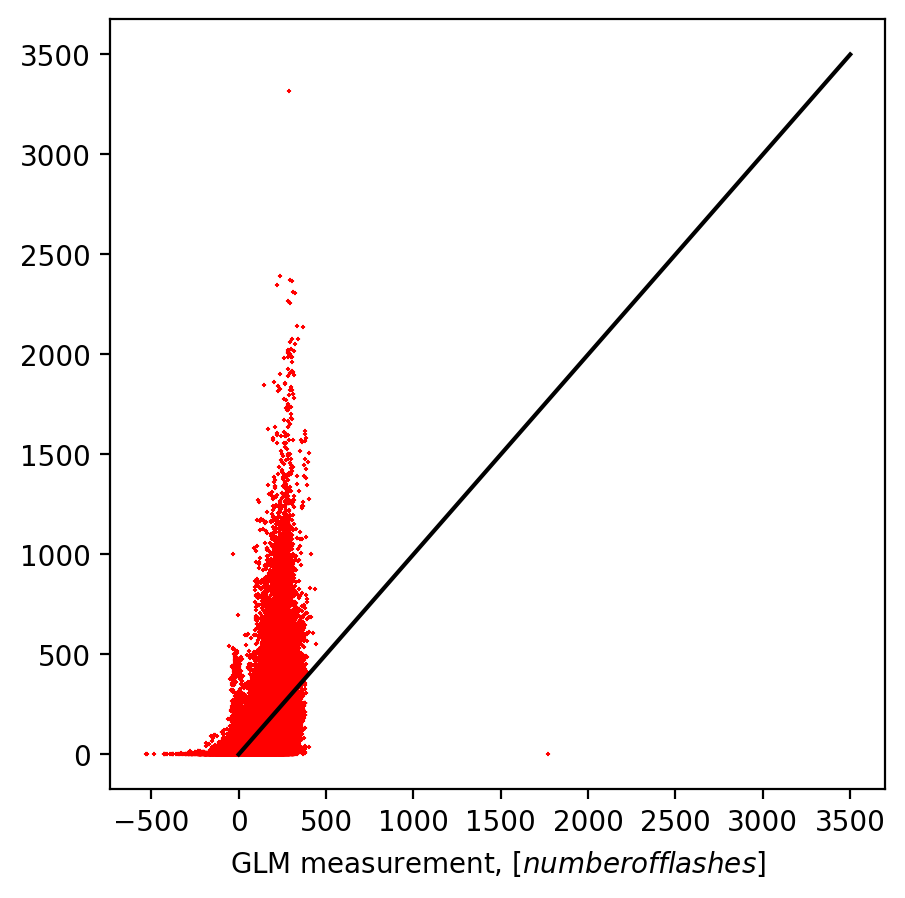

In [11]:
# 予測値の計算
yhat = model.predict(X_validate)

fig, ax = plt.subplots(figsize=(5, 5))

# 予測値（検証データの X からの予測） - 真値（検証データの y）をプロット
ax.scatter(yhat, y_validate, color="r", s=1, marker="+")
ax.plot([0, 3500], [0, 3500], "-k")  # 対角線
ax.set_xlabel("ML Prediction, [$number of flashes$]")
ax.set_xlabel("GLM measurement, [$number of flashes$]")

先ほどよりは対応はよくなりましたが予測性能はよくありません。
最低輝度温度と発雷数の間に非線形な関係があることを考えればこの結果も理解できるでしょう。

学習させたモデルの検証を行うための指標を計算しましょう。
回帰モデルの評価に使う指標は分類問題の場合と少し異なります。よく使われる指標は平均バイアス、平均絶対誤差（MAE）、二条平均誤差（RMSE）、決定係数（$R^2$）です。

$$\mathrm{Bias}=\frac{1}{N}\sum_{j=1}^N(y_{j}-\hat{y}_{j})$$

$$\mathrm{MAE}=\frac{1}{N}\sum_{j=1}^{N}|y_{j}-\hat{y}_{j}|$$

$$\mathrm{RMSE}=\sqrt{\frac{1}{N}\sum_{j=1}^N(y_j-\hat{y}_{j})^2}$$

$$\mathrm{R^2}=1-\frac{\sum_{j=1}^{N}(y_j-\hat{y}_j)^2}{\sum_{j=1}^{N}(y_{j}-\bar{y})^2}$$

このノートではユーティリティ関数を使ってこれらの指標を計算します。計算方法はコードを確認してみてください。


In [12]:
from gewitter_functions import get_mae, get_rmse, get_bias, get_r2

yhat = model.predict(X_validate)
mae = get_mae(y_validate, yhat)
rmse = get_rmse(y_validate, yhat)
bias = get_bias(y_validate, yhat)
r2 = get_r2(y_validate, yhat)

print(
    "MAE:{} flashes, RMSE:{} flashes, Bias:{} flashes, Rsquared:{}".format(
        np.round(mae, 2), np.round(rmse, 2), np.round(bias, 2), np.round(r2, 2)
    )
)

MAE:131.15 flashes, RMSE:202.35 flashes, Bias:6.49 flashes, Rsquared:0.19


ここまで簡単な線形回帰モデルで発雷数の予測を行いました。指標を見ても性能はよくありませんでしたが（平均して 30 程度の発雷の見逃し）、
次のノートでは複数の特徴量を用いることで性能のよい ML モデルが作成できることを見ていきます。


### Step 6: 学習済みモデルの保存

モデルを再度学習させるのは時間がかかるので学習済みモデルを保存しておきましょう。
保存の仕方はいろいろありますがこのノートではビルトインパッケージである `pickle` を使ってみます。


In [13]:
import pickle
from pathlib import Path

save_dir = Path("../datasets/sklearnmodels/regression/onefeature")
save_file = save_dir / "LinearRegression.pkl"
if not save_dir.exists():
    save_dir.mkdir(parents=True)
with open(save_file, "wb") as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

### Step 7: 保存したモデルの読み込み

`pickle` で保存したモデルは次のように読み込みます。


In [14]:
import pickle
from pathlib import Path

save_dir = Path("../datasets/sklearnmodels/regression/onefeature")
save_file = save_dir / "LinearRegression.pkl"
if not save_dir.exists():
    save_dir.mkdir(parents=True)
with open(save_file, "rb") as f:
    model = pickle.load(f)

print(model)

LinearRegression()


次のノートでは 36 個の全特徴量を使ってモデルを学習させる方法を見ていきます。ノート 6 は分類問題を、ノート 7 では回帰問題を扱います。
